# Financial Risk Metrics
---
This notebook measures the risk characteristics of the S&P 500 index throughout its entire history. The notebook starts by calculating static risk metrics. Then the notebook explores tail-end risk metrics to quantify large losses with small probabilities. To conclude the experiment, we calculate and observe temporal risk metrics.

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import yfinance as yf

# Import settings
plt.style.use('ggplot')

data_sets = ['^GSPC', '^TNX']

# Download historical S&P 500 and US 10Y Rate data
data = yf.download(data_sets, period='max', interval='1d', auto_adjust=True)['Close']
data.dropna(inplace=True)

# Calculate daily market returns and daily interest rates
data['returns'] = data['^GSPC'].pct_change()
data['rates'] = (data['^TNX'] / 100) / 360 # 360 day period

# Compute the daily excess returns
data['excess_returns'] = data['returns'] - data['rates']
data.dropna(inplace=True)

print(data.describe())

[*********************100%***********************]  2 of 2 completed

Ticker         ^GSPC          ^TNX       returns         rates  excess_returns
count   15848.000000  15848.000000  15848.000000  15848.000000    15848.000000
mean     1038.640378      5.824363      0.000335      0.000162        0.000173
std      1278.490397      2.955619      0.010447      0.000082        0.010448
min        52.320000      0.499000     -0.204669      0.000014       -0.204951
25%       104.897501      3.857750     -0.004334      0.000107       -0.004517
50%       453.604996      5.486000      0.000468      0.000152        0.000301
75%      1359.907501      7.562500      0.005253      0.000210        0.005109
max      6144.149902     15.840000      0.115800      0.000440        0.115693


Average Return:      0.00017283742931042942
Standard Deviation:  0.010447428548701947
Skew of Returns:     -0.5597195508367746
Kurtosis of Returns: 19.45463040640361


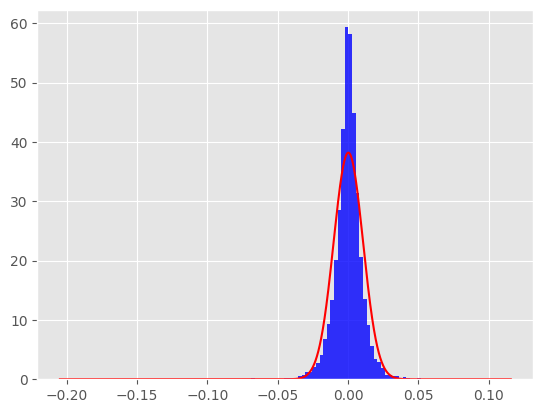

In [13]:
mu = np.mean(data['excess_returns'])
sd = np.std(data['excess_returns'])
skew = data['excess_returns'].skew()
kurt = data['excess_returns'].kurt()

print(f'Average Return:      {mu}')
print(f'Standard Deviation:  {sd}')
print(f'Skew of Returns:     {skew}')
print(f'Kurtosis of Returns: {kurt}')

# Calulate the normal distribution
x = np.linspace(min(data['excess_returns']), max(data['excess_returns']), len(data['excess_returns']))
y = stats.norm.pdf(x, mu, sd)

fig, ax = plt.subplots()

# Plot the return frequency
nBins = int(np.sqrt(len(data['excess_returns'])))
ax.hist(data['excess_returns'], bins=nBins, alpha=0.8, color='blue', label='Return Distribution', density=True)

# Plot the normal distribution
ax.plot(x, y, color='red', label='Normal')
plt.show()

We can observe that the returns for the S&P 500 are only approximately normally distributed. A greater frequency of returns is present closer to the mean, more than the normal distribution suggests. The distribution of returns is almost fully symmetrical, shown by the small skew. Where the divergence from the normal disctribution occurs most is in the tail behavior. The kurtosis is quite high, indicating that there is more probability mass in the tails of the distribution. Becasue the return distribution is only approximately normal, standard deviation is an incomplete measure of risk. More specifically, additional measures are needed to quantify tail risk.

In [14]:
min_return = min(data['excess_returns'])
max_return = max(data['excess_returns'])

print(f'Maximum Return: {max_return}')
print(f'Minimum Return: {min_return}')

Maximum Return: 0.11569311951344163
Minimum Return: -0.2049512524307918


#### 1. Value at Risk (VaR)
Value at Risk is a method of assessing financial risk using standard statistical techniques summarizing the worst-loss over a target horizon that will not be exceeded with a given confidence interval. The 99% VaR may be viewed as the cutoff seperating the 1% worst-case future scenarios from the rest of the distribution.

99% Value at Risk:   -0.028226379867885464
99.9% Value at Risk: -0.061390900299734597


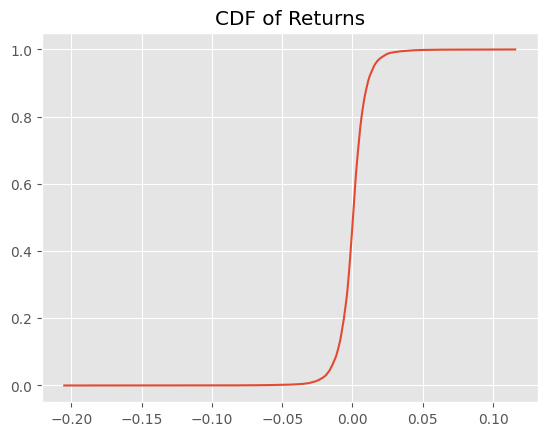

In [15]:
sorted_returns = np.sort(data['excess_returns'])
pct99 = int(0.01 * len(sorted_returns))
pct99_9 = int(0.001 * len(sorted_returns))

# Calculate the sample estimates of VaR (99% and 99.9%)
VaR99 = sorted_returns[pct99]
VaR99_9 = sorted_returns[pct99_9]

print(f'99% Value at Risk:   {VaR99}')
print(f'99.9% Value at Risk: {VaR99_9}')

# Plot the cummulative distribution of returns
cumm_probabilities = np.arange(1, len(sorted_returns) + 1) / len(sorted_returns)

plt.plot(sorted_returns, cumm_probabilities)
plt.title('CDF of Returns')
plt.show()

#### 2. Expected Shortfall
Expected shortfall provides greater insights into the magnitude of returns within the left-tail of the distribution by averaging the returns below a percentile. Value at Risk gives the return at a certain percentile, whereas expected shortfall provides information as to the behavior of the left-tail.

In [16]:
# Average the worst returns in the tail
worst_99pct = sorted_returns[0:pct99+1]
worst_99_9pct = sorted_returns[0:pct99_9+1]

# Calculate the expected shortfall estimate (1% and 0.1%)
excepted_shortfall99 = np.mean(worst_99pct)
expected_shortfall99_9 = np.mean(worst_99_9pct)

print(f'1% Expected Shortfall:   {excepted_shortfall99}')
print(f'0.1% Expected Shortfall: {expected_shortfall99_9}')

1% Expected Shortfall:   -0.04175474249971862
0.1% Expected Shortfall: -0.08689445115891825


#### 3. Lower Partial Standard Deviation

Lower partial standard deviation (LPSD) measures the volatility of negative returns. Becasue investors are primarily concernd with negative deviations from expectation, LPSD quantifies the volatility of negative historical outcomes.

In [17]:
negative_returns = data['excess_returns'][data['excess_returns'] <= 0].to_list()
lpsd = np.std(negative_returns)

print(f'Lower Partial Standard Deviation: {lpsd}')

Lower Partial Standard Deviation: 0.008124706901887128


#### 4. Relative Frequency of 3-Sigma Returns

Negative 3-sigma returns refer to extreme negative outliers (returns) that occur within a return distribution. It measures the frequency of large negative occurences wthin a return distribution. A higher frequency impies that extreme negative returns are more common, hence more risk is associated with the asset.

In [18]:
three_sd = -3 * sd
num_three_sd = len(data['excess_returns'][data['excess_returns'] < three_sd])

three_sd_frequency = (num_three_sd / len(data)) * 100

print(f'Relative Frequency of 3-Sigma Returns: {round(three_sd_frequency, 4)}%')

Relative Frequency of 3-Sigma Returns: 0.6689%


## Temporal Statistics

#### 1. Rolling Statistics

Rolling statistics provide a view as to how risk metrics change through time with a static lookback period. This methodology gives us perspecitve as to how the current situation compares to the historical record.

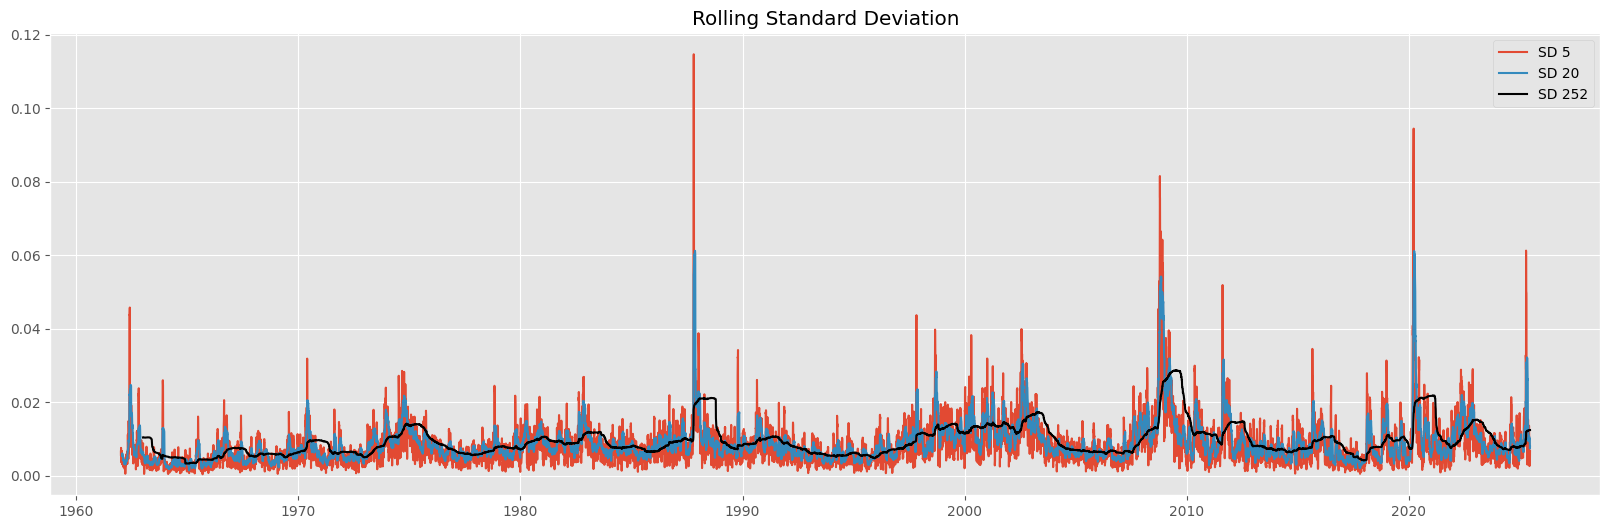

In [19]:
# Compute the rolling standard deviation for different windows
data['rolling_sd_5'] = data['excess_returns'].rolling(window=5).std()     # Weekly
data['rolling_sd_20'] = data['excess_returns'].rolling(window=20).std()   # Monthly
data['rolling_sd_252'] = data['excess_returns'].rolling(window=252).std() # Yearly

plt.figure(figsize=(20, 6))
plt.title('Rolling Standard Deviation')
plt.plot(data['rolling_sd_5'], label='SD 5')
plt.plot(data['rolling_sd_20'], label='SD 20')
plt.plot(data['rolling_sd_252'], label='SD 252', color='black')
plt.legend()
plt.show()

#### 2. Term Structure Statistics

The term structure of statistics provide insights into how risk statistics behave during different time periods. The temporal characteristics of asset returns must correspond to the temporal nature of the investor's investment horizon (expected period of time to hold an investment).

In [20]:
days = [i for i in range(2, 253)]

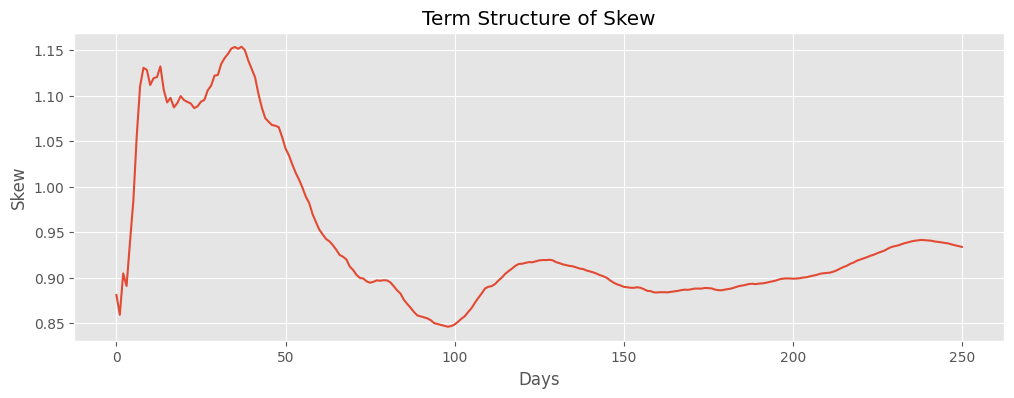

In [21]:
skew_term_structure = []
for day in days:
    shifted_prices = data['^GSPC'].shift(day)
    prices = data['^GSPC']

    r_t = np.log(shifted_prices / prices)

    mu = np.mean(r_t)
    sd = np.std(r_t)

    # Calculate the term Skewness
    term_skew = np.mean(((r_t - mu) / sd) ** 3)
    skew_term_structure.append(term_skew)

# Plot the term structure
plt.figure(figsize=(12, 4))
plt.title('Term Structure of Skew')
plt.xlabel('Days')
plt.ylabel('Skew')
plt.plot(skew_term_structure)
plt.show()


From the term structure of skew, we can observe that the skewness for shorter investment horizons is significantly higher than that of longer horizons. At about 100 days, the skewness gradually increases. This suggests that shorter-term investment horizons experience higher asymetric number of positive daily returns relative to longer investment horizons, on average.

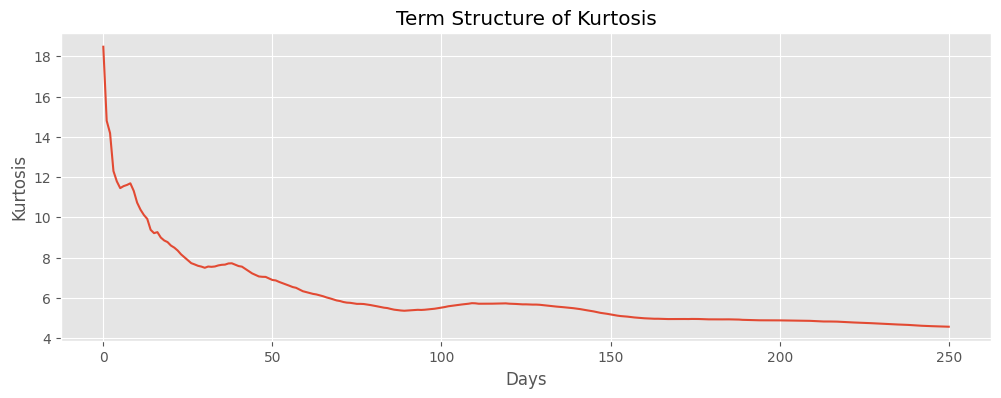

In [22]:
kurtosis_term_structure = []
for day in days:
    shifted_prices = data['^GSPC'].shift(day)
    prices = data['^GSPC']

    r_t = np.log(shifted_prices / prices)

    mu = np.mean(r_t)
    sd = np.std(r_t)

    # Calculate the term Kurtosis
    term_kurtosis = np.mean(((r_t - mu) / sd) ** 4)
    kurtosis_term_structure.append(term_kurtosis)

# Plot the term structure
plt.figure(figsize=(12, 4))
plt.title('Term Structure of Kurtosis')
plt.xlabel('Days')
plt.ylabel('Kurtosis')
plt.plot(kurtosis_term_structure)
plt.show()

From the term structure of kurtosis, we can observe that the level of "fat-tailness" of daily returns decreases with time on average. This suggests that shorter investment horizons are more exposed to larger moves.